# Self-Driving Car Engineer Nanodegree
## Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Camera Calibration

The code for this step is contained in the following cell (cameraCalibration function).
The output of the cameraCalibration function is 
 - Object points : 3d  points in real world space 
 - Image points : 2d points in the image plane

Steps
- Twenty one different images of chessboard pattern are used for camera calibration. 
- convert the images from BGR 2 GRAY scale
- Find the chess board corner using cv2.findChessboardCorners function
- Use cv2.calibrateCamera function to do camera calibration. The output of which is used to undistort the image


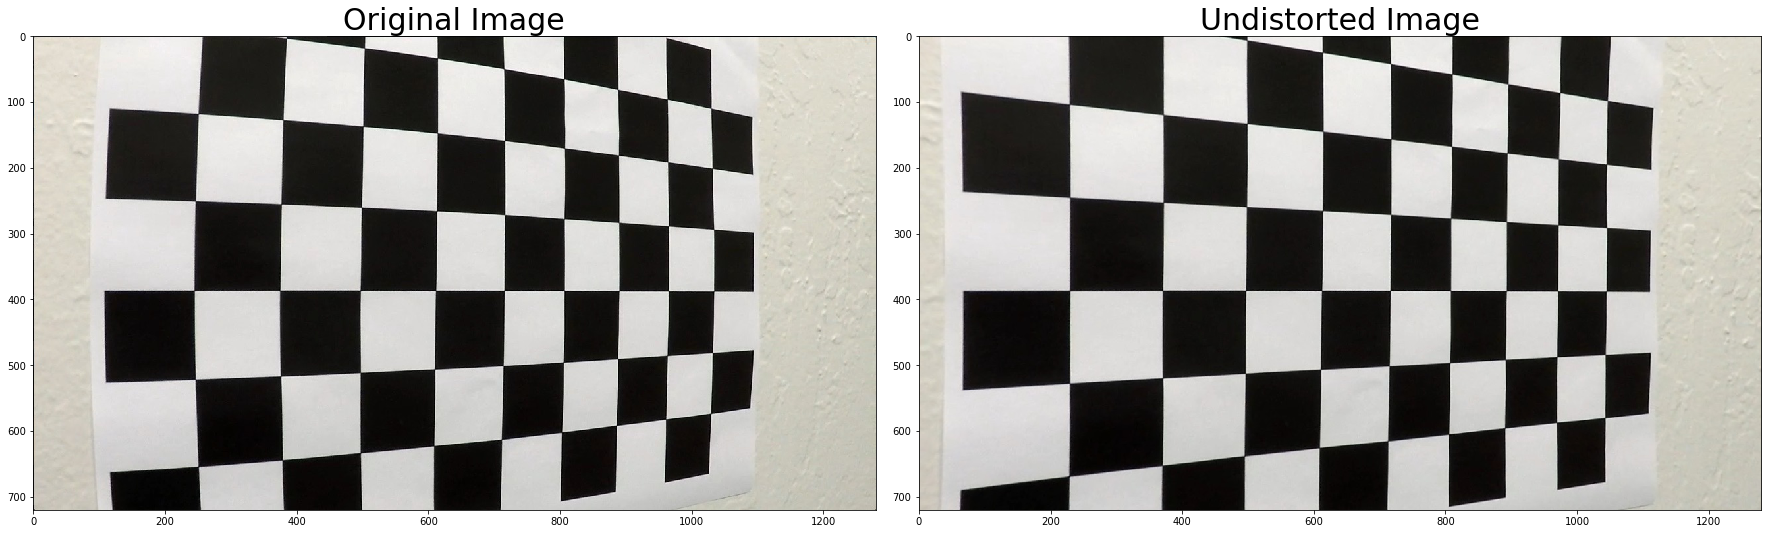

In [167]:
# Import all the packages needed for Advanced lane finding 
import numpy as np    
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import random
%matplotlib inline

images = glob.glob('camera_cal/calibration*.jpg')
one_image = mpimg.imread('camera_cal/calibration5.jpg')

def cameraCalibration(img):
    img_size = one_image.shape[:2]
    objp = np.zeros((6*9,3), np.float32)
    # modify the array 
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
    # idx is the index and fname is the image name
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
       # print (ret, corners.shape)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)


    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size[:2],None,None)
    return ret, mtx, dist, rvecs, tvecs
ret, mtx, dist, rvecs, tvecs = cameraCalibration(one_image)

img = cv2.undistort(one_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(one_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Following is an example of distortion correction image

# Distortion Correction
Distortion correction on one single image


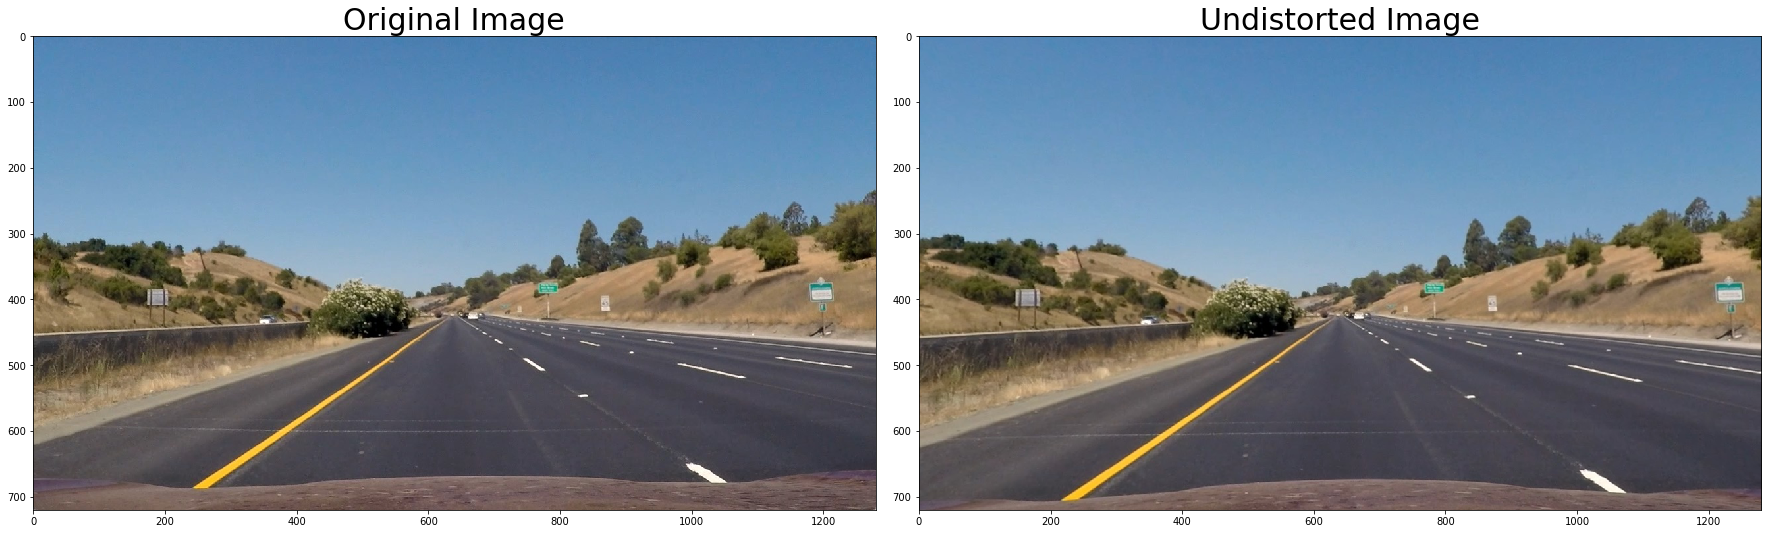

In [168]:
img1 = mpimg.imread('test_images/straight_lines1.jpg')

img = cv2.undistort(img1, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



# Image Threshold

Image is first converted to HLS color space and then Sobel X transform is applied. In the given image, HLS color space works the best in various different lighting conditions.

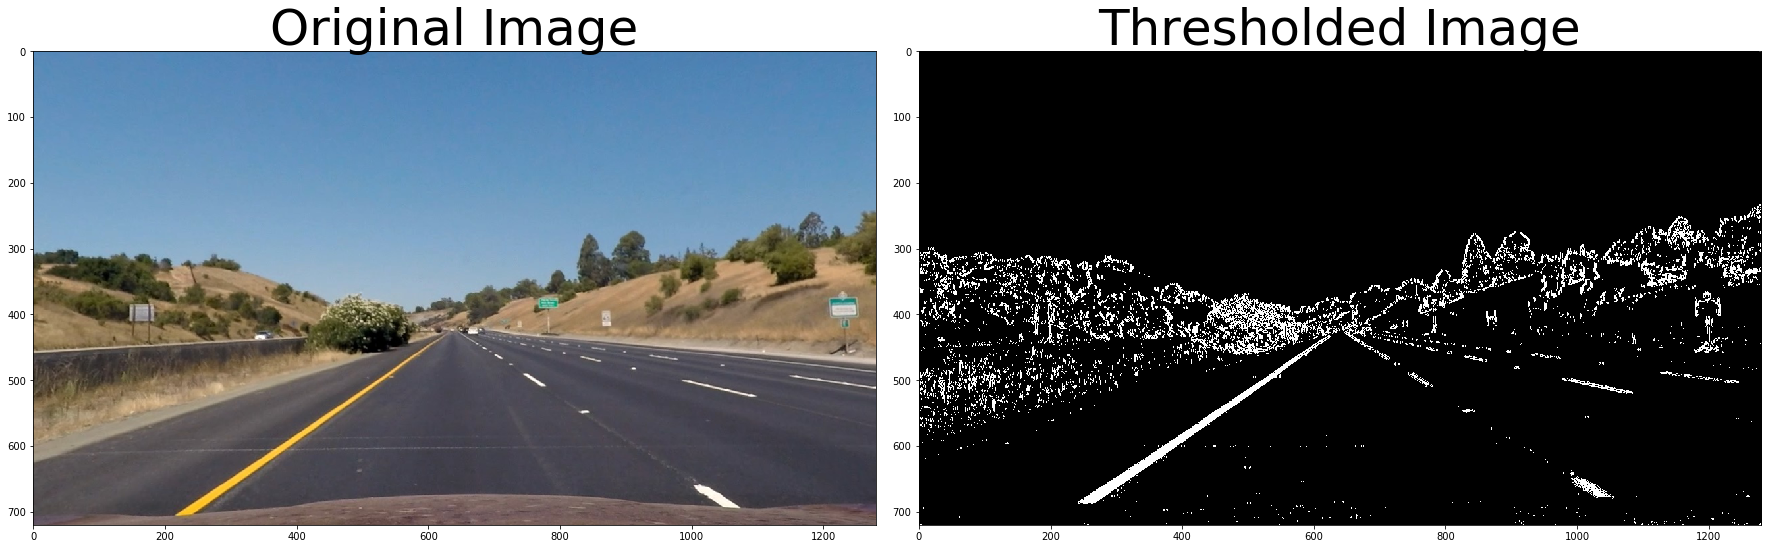

In [169]:
def thresholding(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary


combined_binary = thresholding(img1)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Perspective Transform 

- The source and destinations points are initially determined manually. Further corrections are done through iterations.



# Coordinates of the source points 
    sbot_l = (300,720) 
    sbot_r = (1130, 720)
    stop_l = (592, 455)
    stop_r = (690, 455)

# Coordinates of the destination points 
    dbot_l = (320,720) 
    dbot_r = (1100,720)
    dtop_l = (320 ,1)
    dtop_r = (1130,1)

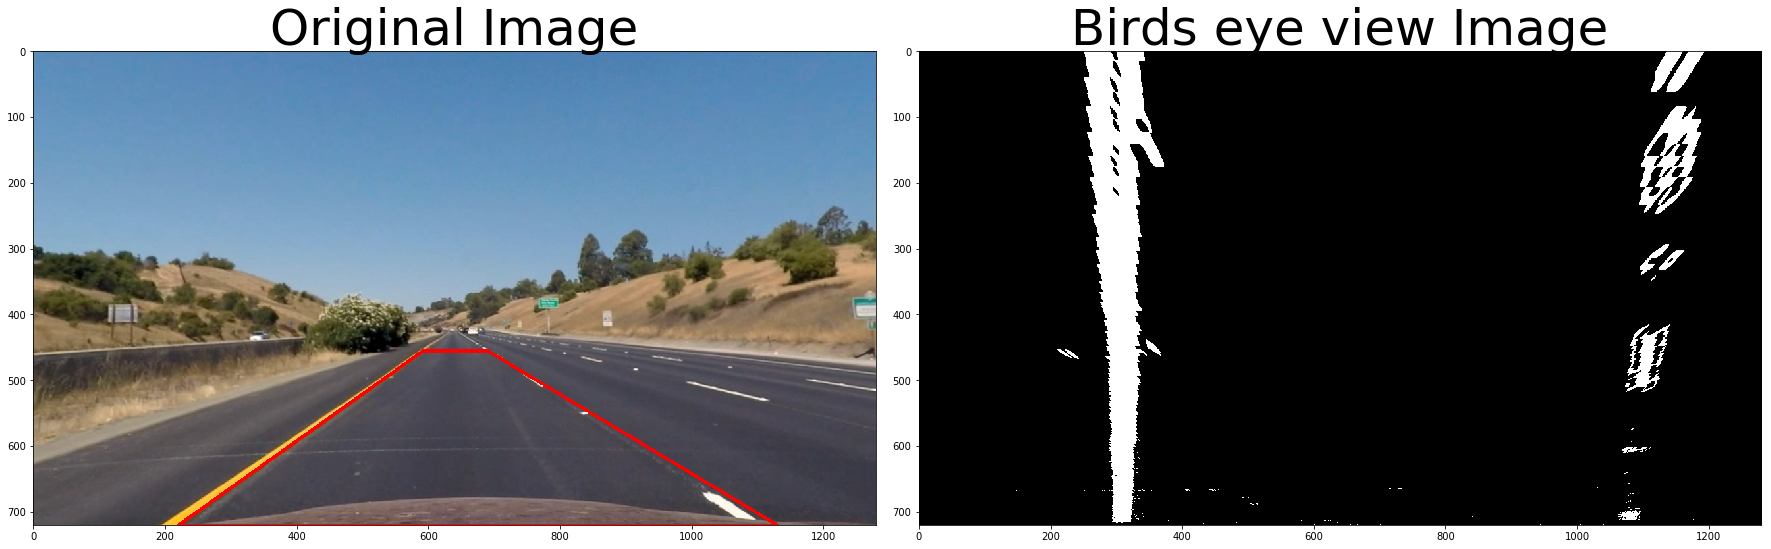

In [185]:

def perspective_transform(img,mtx,dist):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    
# Coordinates of the source points 
    sbot_l = (300,720) 
    sbot_r = (1130, 720)
    stop_l = (592, 455)
    stop_r = (690, 455)

# Coordinates of the destination points 
    dbot_l = (320,720) 
    dbot_r = (1100,720)
    dtop_l = (320 ,1)
    dtop_r = (1130,1)
    
    src = np.float32([sbot_l,sbot_r,stop_l,stop_r])
    image_shape = img.shape
    img_size = (image_shape[1], image_shape[0])

    pts = np.array([sbot_l,sbot_r,stop_r,stop_l], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    ps = cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    dst = np.float32([dbot_l,dbot_r,dtop_l,dtop_r])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return ps, warped, M, M_inv


ps,transformed,M, M_inv = perspective_transform(combined_binary,mtx,dist)
pso,transformedx,Mx, M_invx = perspective_transform(img,mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(pso)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(transformed, cmap='gray')
ax2.set_title('Birds eye view Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Lane line pixel detection

A sliding window search is performed to detect the lane pixels. A histogram is used as a starting point to identify the starting points of the lane. Once the starting points are initialized, sliding window search is used to detect the remaining lane pixels. 
- Number of windows used = 15
- Number of minimum pixels detected = 80
- Margin (width of the window +/- margin) = 80



(720, 0)

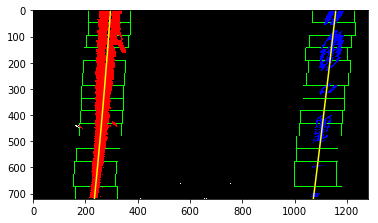

In [184]:
def sliding_window(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 80
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
     # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return  out_img,left_fit, right_fit, left_fitx, right_fitx,ploty

out_img,left_fit, right_fit, left_fitx, right_fitx,ploty = sliding_window(transformed)



plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720,0)

(720, 0)

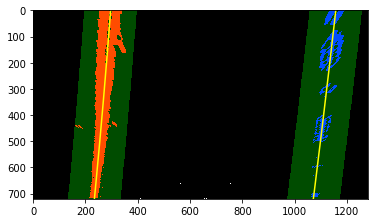

In [172]:
def non_sliding_window(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = []
    right_lane_inds = []
    out_img = np.dstack((img, img, img))*255

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
        # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)



    return  result, left_fitx, right_fitx, ploty

out_img, left_fitx, right_fitx, ploty = non_sliding_window(transformed, left_fit, right_fit)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0],0)


In [177]:
def radius(ploty,left_fitx,right_fitx,img):
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    diff_radius = abs(left_curverad-right_curverad)
   # print(left_curverad, 'm', right_curverad, 'm', diff_radius)
    #Find Car position
    car_p = img.shape[1]/2
    lane_p = (left_fitx[0]+right_fitx[0])/2
    offset_from_center = (lane_p-car_p)*xm_per_pix
    return left_curverad,right_curverad,offset_from_center

left_curverad,right_curverad,offset_from_center  = radius(ploty,left_fitx,right_fitx,img)
print ("Left lane radius",left_curverad)
print ("Right lane radius", right_curverad)
print ("Offset from center", offset_from_center)



Left lane radius 11045.4678243
Right lane radius 19117.0484691
Offset from center 0.45934970041


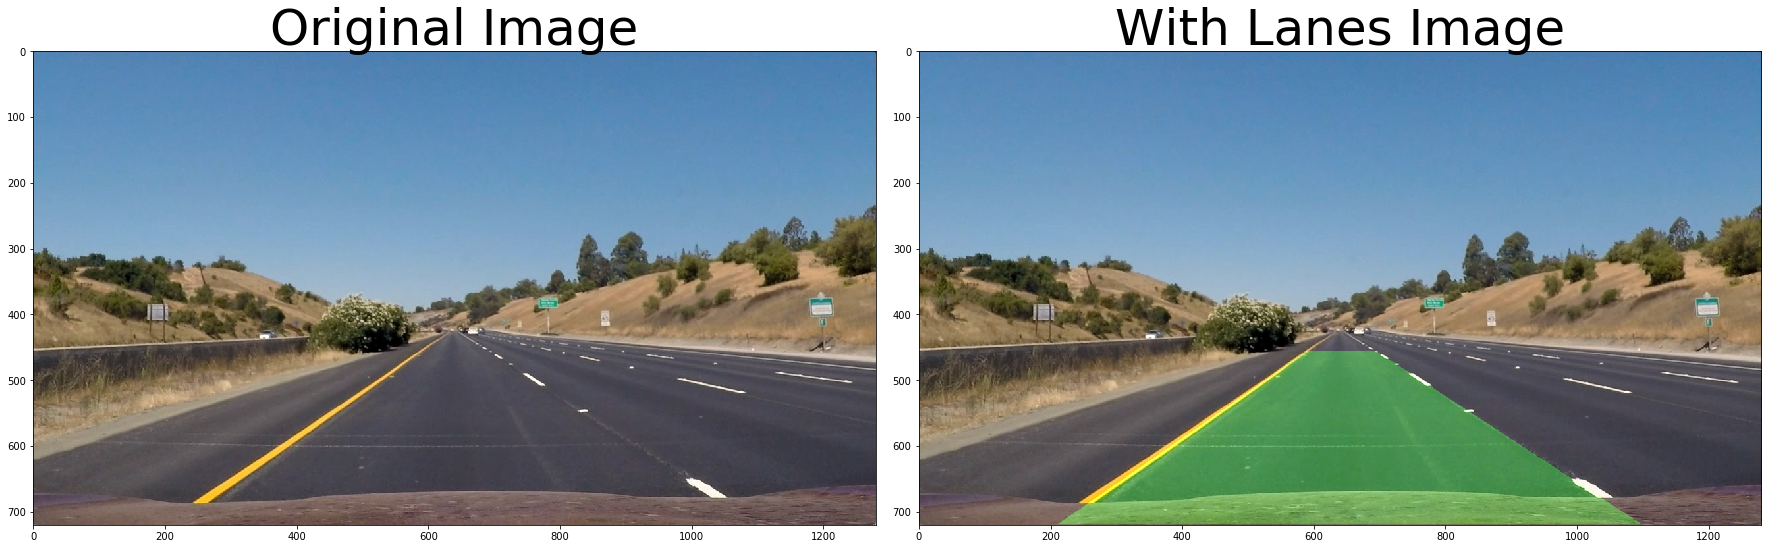

In [178]:
def draw_lanes(warped,img,left_fitx,right_fitx,ploty,M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result


img1 = mpimg.imread('test_images/straight_lines1.jpg')


result = draw_lanes(transformed,img1,left_fitx,right_fitx,ploty,M_inv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('With Lanes Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Final Pipeline 

- 15 frames (mean is taken) are use to smoothen the final lane lines.


0.0


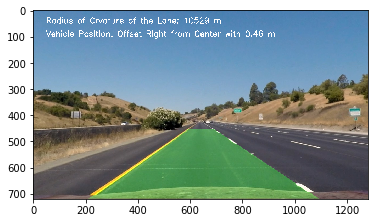

In [180]:
ret, mtx, dist, rvecs, tvecs = cameraCalibration(one_image)

frames = 15
left_fit_str = None
right_fit_str = None
compare = None

def pipeline(img): 
    combined_binary = thresholding(img)
    copy,warped, M, M_inv = perspective_transform(combined_binary,mtx,dist)
    out_img,left_fit, right_fit, left_fitx, right_fitx,ploty = sliding_window(warped)
    left_curverad,right_curverad,offset_from_center =radius(ploty,left_fitx,right_fitx,warped)
    avg_radius_meters = np.mean([left_curverad, right_curverad])


    global right_fit_str
    global left_fit_str
    global compare
    
    if compare is None:
        compare = combined_binary
        
    ret = cv2.matchShapes(compare, combined_binary, 1, 0.0)
    print (ret)
    if ret < 50:
        old_img_lines = combined_binary

        if left_fit_str is None:
            left_fit_str = np.array([left_fitx])

        if right_fit_str is None:
            right_fit_str = np.array([right_fitx])

        left_fit_str = np.append(left_fit_str, [left_fitx], axis=0)[-frames:]
        right_fit_str = np.append(right_fit_str, [right_fitx], axis=0)[-frames:]

    # Compute the mean
    left_fit_mean = np.mean(left_fit_str, axis=0)
    right_fit_mean = np.mean(right_fit_str, axis=0)

    result = draw_lanes(warped,img,left_fit_mean,right_fit_mean,ploty,M_inv)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Crvature of the Lane: {:.0f} m".format(avg_radius_meters)
    cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
    text = "Vehicle Position: Offset Right from Center with {:.2f} m".format(offset_from_center)
    cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)


    return result

test = pipeline(img)

plt.imshow(test)




In [181]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
counter = 0
write_output = 'project_video_cha.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("project_video.mp4")


write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

8.294092358949905
[MoviePy] >>>> Building video project_video_cha.mp4
[MoviePy] Writing video project_video_cha.mp4


  0%|          | 1/1261 [00:00<02:08,  9.81it/s]

8.294092358949905
3.5296754920832627


  0%|          | 3/1261 [00:00<02:02, 10.26it/s]

6.191815692014043
232.09924019481468


  0%|          | 5/1261 [00:00<01:57, 10.66it/s]

6.702475483384994
21.04523767807303


  1%|          | 7/1261 [00:00<01:54, 10.93it/s]

27.336349092895496
6.335612812747977


  1%|          | 9/1261 [00:00<01:54, 10.91it/s]

4.392262405251616
4.593829677328973


  1%|          | 11/1261 [00:00<01:52, 11.08it/s]

5.295827478821693
15.973098773711076
4.624883890403225


  1%|          | 13/1261 [00:01<01:55, 10.78it/s]

22.569247212866994


  1%|          | 15/1261 [00:01<01:54, 10.86it/s]

28.233699962735557
9.64100718871662
6.763350036329413


  1%|▏         | 17/1261 [00:01<01:55, 10.75it/s]

10.491369161161256


  2%|▏         | 19/1261 [00:01<01:54, 10.87it/s]

142.7661223462834
20.12970965792674


  2%|▏         | 21/1261 [00:01<01:52, 11.03it/s]

46.28578381186341
24.832001324721592


  2%|▏         | 23/1261 [00:02<01:50, 11.16it/s]

48.82640881891468
32.20872641530757


  2%|▏         | 25/1261 [00:02<01:51, 11.11it/s]

36.223600760814406
11.588631094065061


  2%|▏         | 27/1261 [00:02<01:49, 11.30it/s]

5.511044933982043
5.926845575302988


  2%|▏         | 29/1261 [00:02<01:48, 11.33it/s]

5.988604305313319
8.659326056908272
9.79603361257076


  2%|▏         | 31/1261 [00:02<01:51, 11.00it/s]

9.335906536282092

  3%|▎         | 33/1261 [00:02<01:51, 11.06it/s]


9.933014306386188
15.347486241568344


  3%|▎         | 35/1261 [00:03<01:51, 11.02it/s]

18.73071279331022
9.329070903410763


  3%|▎         | 37/1261 [00:03<01:50, 11.13it/s]

3.860264868273626
4.083907850927445
4.1481209248404625


  3%|▎         | 39/1261 [00:03<01:51, 10.99it/s]

4.553772488874463


  3%|▎         | 41/1261 [00:03<01:50, 11.04it/s]

4.811728809582512
4.969417590508611


  3%|▎         | 43/1261 [00:03<01:56, 10.47it/s]

5.092063425974622
5.033264401255947
4.879388917158822


  4%|▍         | 48/1261 [00:04<02:15,  8.95it/s]

5.042033017134488
4.5368873539772485
4.565381483997124


  4%|▍         | 50/1261 [00:04<02:11,  9.23it/s]

4.664593759005545
4.990293011468669


  4%|▍         | 52/1261 [00:04<02:11,  9.21it/s]

25.360830733017927
2.4206446586193717


  4%|▍         | 54/1261 [00:05<02:12,  9.10it/s]

4.249483543372957
7.125926874140699


  4%|▍         | 56/1261 [00:05<02:11,  9.14it/s]

6.0345197680673985
10.31228006223194


  5%|▍         | 58/1261 [00:05<02:17,  8.76it/s]

4.843318699912352
5.871060045156387


  5%|▍         | 60/1261 [00:05<02:10,  9.23it/s]

5.940423413764734
5.999661000288075


  5%|▍         | 62/1261 [00:06<02:15,  8.86it/s]

6.000952072311749
6.026395438483329


  5%|▌         | 64/1261 [00:06<02:12,  9.03it/s]

6.08481927040024
5.875028662233307


  5%|▌         | 66/1261 [00:06<02:09,  9.23it/s]

5.692683233486079
6.282571470174605


  5%|▌         | 68/1261 [00:06<02:06,  9.40it/s]

4.091479156499316
4.601668884706006


  5%|▌         | 69/1261 [00:06<02:10,  9.15it/s]

4.558791803534067
4.700717881698447
6.056497840163631


  6%|▌         | 73/1261 [00:07<02:04,  9.53it/s]

5.8297228226847935
5.874444864487431


  6%|▌         | 75/1261 [00:07<02:13,  8.87it/s]

6.359277447113604
4.620187576394015


  6%|▌         | 77/1261 [00:07<02:13,  8.85it/s]

6.165149931554115
21.224175508118556


  6%|▋         | 79/1261 [00:07<02:11,  9.00it/s]

3.973089546201851
4.197778562250111


  6%|▋         | 81/1261 [00:08<02:10,  9.05it/s]

4.330942147994451
4.845778125332899


  7%|▋         | 83/1261 [00:08<02:12,  8.89it/s]

4.752534077741636
4.846646524889545


  7%|▋         | 85/1261 [00:08<02:07,  9.22it/s]

4.939348511236382
4.958410184077269


  7%|▋         | 87/1261 [00:08<02:04,  9.42it/s]

4.867489496589155
5.131892331720241


  7%|▋         | 89/1261 [00:08<02:09,  9.05it/s]

4.802268401622262
4.921456747351898


  7%|▋         | 91/1261 [00:09<02:15,  8.62it/s]

4.7199124938705035
4.487705272465837


  7%|▋         | 93/1261 [00:09<02:16,  8.58it/s]

4.592681491262365
4.8868516062159735


  8%|▊         | 95/1261 [00:09<02:14,  8.68it/s]

5.094686161302372
5.20012243778748


  8%|▊         | 97/1261 [00:09<02:16,  8.53it/s]

4.949734046055354
4.978971108523331


  8%|▊         | 99/1261 [00:10<02:09,  8.99it/s]

4.987403144103546
4.69103123438218


  8%|▊         | 101/1261 [00:10<02:13,  8.67it/s]

5.066089138906129
4.851675028355262


  8%|▊         | 103/1261 [00:10<02:12,  8.73it/s]

4.776576454458291
4.723318255473878


  8%|▊         | 105/1261 [00:10<02:13,  8.68it/s]

4.612635246991091
4.50453167564716


  8%|▊         | 107/1261 [00:11<02:09,  8.94it/s]

4.911988548296595
4.929305136609093


  9%|▊         | 109/1261 [00:11<02:10,  8.81it/s]

4.710742124061604
4.615409123318635


  9%|▊         | 110/1261 [00:11<02:08,  8.99it/s]

4.463455434887681
4.43498217901464
4.756516451714631


  9%|▉         | 114/1261 [00:11<02:10,  8.82it/s]

5.054093370192985
4.821673166018551


  9%|▉         | 116/1261 [00:12<02:08,  8.92it/s]

4.583188595715224
4.8183657773967985


  9%|▉         | 118/1261 [00:12<02:10,  8.75it/s]

4.869459312691857
5.006450203233373


 10%|▉         | 120/1261 [00:12<02:04,  9.13it/s]

5.079918131550706
4.976958328332709


 10%|▉         | 122/1261 [00:12<02:06,  8.99it/s]

5.252597691326201
5.238876945327438


 10%|▉         | 124/1261 [00:12<02:06,  9.01it/s]

5.285495738213316
5.197972681874354


 10%|▉         | 126/1261 [00:13<02:09,  8.77it/s]

5.277046973968067
5.3170415401424655


 10%|█         | 128/1261 [00:13<02:07,  8.92it/s]

5.260031149232988
5.133276680682914


 10%|█         | 130/1261 [00:13<02:12,  8.55it/s]

5.1880254905626355
4.88822671865724


 10%|█         | 132/1261 [00:13<02:12,  8.50it/s]

5.069539274079363
5.3093346454031325


 11%|█         | 134/1261 [00:14<02:14,  8.36it/s]

5.152920072338976
5.279674210570741


 11%|█         | 136/1261 [00:14<02:15,  8.30it/s]

5.302775305270868
5.0547627377412505


 11%|█         | 138/1261 [00:14<02:16,  8.25it/s]

5.052105641049757
4.996600657325785


 11%|█         | 140/1261 [00:14<02:20,  7.96it/s]

4.747662584126909
4.582419985741587


 11%|█▏        | 142/1261 [00:15<02:21,  7.92it/s]

23.250480341616
6.073336856314667


 11%|█▏        | 144/1261 [00:15<02:19,  8.03it/s]

4.814992790885328
6.865197828434763


 12%|█▏        | 146/1261 [00:15<02:11,  8.50it/s]

18.848910381308052
6.134785809636092


 12%|█▏        | 148/1261 [00:15<02:18,  8.05it/s]

6.132723388091951
5.890540412746688


 12%|█▏        | 150/1261 [00:16<02:15,  8.22it/s]

5.878617935987671
5.672832881712997


 12%|█▏        | 152/1261 [00:16<02:16,  8.14it/s]

5.620217598815877
5.6945598580859365


 12%|█▏        | 154/1261 [00:16<02:14,  8.23it/s]

5.4928290570590175
5.180474353257271


 12%|█▏        | 156/1261 [00:16<02:15,  8.15it/s]

5.332109027182867
8.560152775388447


 13%|█▎        | 158/1261 [00:17<02:10,  8.42it/s]

6.157350238547522
5.159880320941018


 13%|█▎        | 160/1261 [00:17<02:08,  8.54it/s]

5.235598655558119
5.145914565272551


 13%|█▎        | 162/1261 [00:17<02:06,  8.68it/s]

4.637624384227333
4.534185473513856


 13%|█▎        | 164/1261 [00:17<02:06,  8.67it/s]

11.9702140682211
13.111980599711625


 13%|█▎        | 166/1261 [00:17<02:14,  8.12it/s]

11.396738499746974
3.7333268562832687


 13%|█▎        | 168/1261 [00:18<02:18,  7.88it/s]

5.101627808483546
5.489984511019686


 13%|█▎        | 170/1261 [00:18<02:20,  7.74it/s]

5.263094917120339
5.145439678491777


 14%|█▎        | 172/1261 [00:18<02:20,  7.74it/s]

4.511281060354313
4.32143676852275


 14%|█▍        | 174/1261 [00:19<02:29,  7.27it/s]

4.415098895385233
4.679549123373626


 14%|█▍        | 176/1261 [00:19<02:25,  7.43it/s]

5.0772974183261095
4.992814404467577


 14%|█▍        | 178/1261 [00:19<02:25,  7.44it/s]

4.660189967202126
5.330445483014854


 14%|█▍        | 180/1261 [00:19<02:22,  7.61it/s]

5.347903908602773
5.562822534479771


 14%|█▍        | 182/1261 [00:20<02:11,  8.23it/s]

5.530213006095283
5.515652900097907


 15%|█▍        | 184/1261 [00:20<02:04,  8.63it/s]

5.493946386117411
4.925772845697391


 15%|█▍        | 186/1261 [00:20<02:06,  8.53it/s]

4.950404262176679
5.155299066493761


 15%|█▍        | 188/1261 [00:20<02:14,  7.96it/s]

5.395798384786879
5.178794902296753


 15%|█▌        | 190/1261 [00:21<02:04,  8.63it/s]

5.096362040126372
5.3645323322579


 15%|█▌        | 192/1261 [00:21<02:08,  8.33it/s]

5.341545506549575
5.541205355889403


 15%|█▌        | 194/1261 [00:21<02:09,  8.23it/s]

5.610168520048845
5.514533352587856


 16%|█▌        | 196/1261 [00:21<02:02,  8.73it/s]

5.520764621035727
5.426207128674307


 16%|█▌        | 198/1261 [00:21<02:07,  8.31it/s]

5.31182137311138
5.043360628781558


 16%|█▌        | 200/1261 [00:22<02:11,  8.09it/s]

5.205461131662345
5.42571401019317


 16%|█▌        | 202/1261 [00:22<02:06,  8.35it/s]

5.15556354507804
5.417900309047906


 16%|█▌        | 204/1261 [00:22<02:05,  8.45it/s]

5.419676443740613
5.3626703266377875


 16%|█▋        | 206/1261 [00:22<02:08,  8.20it/s]

5.522268449645596
5.462249504724329


 16%|█▋        | 208/1261 [00:23<02:14,  7.85it/s]

5.645675637443846
14.937606760936141


 17%|█▋        | 210/1261 [00:23<02:14,  7.83it/s]

10.530467652960954
2.97470150700763


 17%|█▋        | 212/1261 [00:23<02:15,  7.76it/s]

9.299860535890492
8.827860599178003


 17%|█▋        | 214/1261 [00:24<02:18,  7.54it/s]

8.772171169504034
7.20334857601118


 17%|█▋        | 216/1261 [00:24<02:19,  7.50it/s]

5.751976698752363
5.574865816702171


 17%|█▋        | 218/1261 [00:24<02:26,  7.14it/s]

5.180298580264499
5.154952764689341


 17%|█▋        | 220/1261 [00:24<02:21,  7.35it/s]

5.266369532679079
5.255677257735453


 18%|█▊        | 222/1261 [00:25<02:19,  7.47it/s]

6.6473722189203395
6.391973333738689


 18%|█▊        | 224/1261 [00:25<02:19,  7.46it/s]

6.068421733090567
5.623765103886976


 18%|█▊        | 226/1261 [00:25<02:19,  7.42it/s]

5.432504573104884
5.38136374187233


 18%|█▊        | 228/1261 [00:25<02:19,  7.43it/s]

5.337187467409914
5.086068482339013


 18%|█▊        | 230/1261 [00:26<02:20,  7.32it/s]

4.967648838240715
4.9247741194563845


 18%|█▊        | 232/1261 [00:26<02:14,  7.63it/s]

5.010672481913276
5.142065587364524


 19%|█▊        | 234/1261 [00:26<02:08,  7.97it/s]

5.431987474395191
5.387968412623952


 19%|█▊        | 236/1261 [00:26<02:09,  7.93it/s]

5.39947345673383
5.320226917229109


 19%|█▉        | 238/1261 [00:27<02:17,  7.46it/s]

5.5023925170284675
5.62373834668667


 19%|█▉        | 240/1261 [00:27<02:16,  7.45it/s]

5.5217528820533115
5.158093394413253


 19%|█▉        | 242/1261 [00:27<02:14,  7.58it/s]

5.2257354796060955
5.445204218270754


 19%|█▉        | 244/1261 [00:28<02:09,  7.83it/s]

5.479078034398726
5.509175591497764


 20%|█▉        | 246/1261 [00:28<02:11,  7.71it/s]

5.724766502156243
5.477855246617423


 20%|█▉        | 248/1261 [00:28<02:11,  7.69it/s]

5.544731233965724
5.590889381160697


 20%|█▉        | 250/1261 [00:28<02:13,  7.57it/s]

5.434872838568852
5.408104787634781


 20%|█▉        | 252/1261 [00:29<02:13,  7.55it/s]

5.472915192236143
5.403826285011352


 20%|██        | 254/1261 [00:29<02:30,  6.68it/s]

5.265092858287213
5.2204385687705654


 20%|██        | 256/1261 [00:29<02:21,  7.10it/s]

5.237105347794601
5.230234881669855


 20%|██        | 258/1261 [00:29<02:16,  7.34it/s]

5.668538346310337
5.5751768402909345


 21%|██        | 260/1261 [00:30<02:09,  7.74it/s]

5.408574321495662
5.422643683580924


 21%|██        | 262/1261 [00:30<02:09,  7.70it/s]

5.519307412861284
5.681098714289723


 21%|██        | 264/1261 [00:30<02:06,  7.87it/s]

5.418759981887424
5.306424818901819


 21%|██        | 266/1261 [00:30<02:00,  8.24it/s]

5.234583535974857
5.306240922904221


 21%|██▏       | 268/1261 [00:31<02:05,  7.89it/s]

5.2303090375469825
5.149596369382345


 21%|██▏       | 270/1261 [00:31<02:02,  8.12it/s]

5.247205010069652
5.295327453626418


 22%|██▏       | 272/1261 [00:31<02:00,  8.20it/s]

5.467440635979754
5.418282203993563


 22%|██▏       | 274/1261 [00:31<01:59,  8.28it/s]

5.373299628946904
5.377661782118581


 22%|██▏       | 276/1261 [00:32<01:58,  8.32it/s]

5.489774501946704
5.246871085767905


 22%|██▏       | 278/1261 [00:32<02:00,  8.16it/s]

5.118181209262579
5.079147073916128


 22%|██▏       | 280/1261 [00:32<01:55,  8.53it/s]

5.023755602407662
5.075909411462828


 22%|██▏       | 282/1261 [00:32<01:53,  8.62it/s]

5.579366219160709
5.404266587215349


 23%|██▎       | 284/1261 [00:33<01:59,  8.17it/s]

5.529823527963922
5.494666425140881


 23%|██▎       | 286/1261 [00:33<02:01,  7.99it/s]

5.21126800234369
5.240070840326605


 23%|██▎       | 288/1261 [00:33<02:02,  7.96it/s]

5.144139398671735
5.1996898395520885


 23%|██▎       | 290/1261 [00:33<01:57,  8.29it/s]

4.880223601119862
5.024967622107533


 23%|██▎       | 292/1261 [00:34<01:52,  8.59it/s]

5.016395159843156
5.273657424369841


 23%|██▎       | 294/1261 [00:34<01:58,  8.17it/s]

5.363196568565799
5.28201618203115


 23%|██▎       | 296/1261 [00:34<01:58,  8.15it/s]

5.25657866613221
5.195091784526683


 24%|██▎       | 298/1261 [00:34<01:55,  8.32it/s]

4.9735095861859975
5.811530880388603


 24%|██▍       | 300/1261 [00:35<01:55,  8.31it/s]

5.686652678996557
5.1790008781389485


 24%|██▍       | 302/1261 [00:35<02:00,  7.93it/s]

5.0118560820770295
5.01385164355305


 24%|██▍       | 304/1261 [00:35<01:57,  8.11it/s]

4.915044079435504
4.859193521404951


 24%|██▍       | 306/1261 [00:35<01:55,  8.30it/s]

5.497067100961345
5.7677535016145605


 24%|██▍       | 308/1261 [00:36<01:53,  8.40it/s]

5.526549733103738
5.270321420336096


 25%|██▍       | 310/1261 [00:36<01:58,  8.01it/s]

5.262010354942708
5.389965864947608


 25%|██▍       | 312/1261 [00:36<01:58,  8.02it/s]

5.1933505434476315
5.157406434781024


 25%|██▍       | 314/1261 [00:36<01:55,  8.18it/s]

5.213100990401245
5.230647743145351


 25%|██▌       | 316/1261 [00:37<01:53,  8.30it/s]

5.227735126396523
5.1429548782719205


 25%|██▌       | 318/1261 [00:37<01:58,  7.94it/s]

5.368695959203943
5.408936154777171


 25%|██▌       | 320/1261 [00:37<02:00,  7.84it/s]

5.43508101603503
5.471094238181515


 26%|██▌       | 322/1261 [00:37<02:02,  7.66it/s]

5.5507100436699215
5.947819866231713


 26%|██▌       | 324/1261 [00:38<01:59,  7.83it/s]

6.124982349977322
6.0671389570299645


 26%|██▌       | 326/1261 [00:38<02:00,  7.75it/s]

5.978876181459745
6.060473707563066


 26%|██▌       | 328/1261 [00:38<01:55,  8.07it/s]

6.092537436709213
5.98071227747675


 26%|██▌       | 330/1261 [00:38<01:50,  8.41it/s]

7.920852567513592
7.87495478656209


 26%|██▋       | 332/1261 [00:39<01:48,  8.60it/s]

9.725743141021493
7.819402257151809


 26%|██▋       | 334/1261 [00:39<01:51,  8.35it/s]

6.959357270194374
7.792819906008359


 27%|██▋       | 336/1261 [00:39<01:52,  8.24it/s]

7.2796672240264115
6.339244607649434


 27%|██▋       | 338/1261 [00:39<01:54,  8.09it/s]

6.518494916263167
6.821313159712758


 27%|██▋       | 340/1261 [00:40<01:56,  7.88it/s]

6.989040176695866
6.858284893973398


 27%|██▋       | 342/1261 [00:40<01:52,  8.20it/s]

7.9021687782858105
9.798172156904911


 27%|██▋       | 344/1261 [00:40<01:49,  8.41it/s]

9.722931498325828
9.197015037271807


 27%|██▋       | 346/1261 [00:40<01:48,  8.47it/s]

8.697244445143436
10.869403292959614


 28%|██▊       | 348/1261 [00:40<01:46,  8.57it/s]

10.050079043373653
8.175359523412755


 28%|██▊       | 350/1261 [00:41<01:46,  8.59it/s]

7.504100688503259
7.2308814345859105


 28%|██▊       | 352/1261 [00:41<01:51,  8.16it/s]

6.611893185959309
6.151187545996317


 28%|██▊       | 354/1261 [00:41<01:59,  7.61it/s]

6.405197660448447
8.615536841541168


 28%|██▊       | 356/1261 [00:42<02:12,  6.85it/s]

12.872196486987008
12.532285203276832


 28%|██▊       | 358/1261 [00:42<02:12,  6.83it/s]

7.895897567152277
5.2389309713418255


 29%|██▊       | 360/1261 [00:42<02:12,  6.82it/s]

10.84637483206032
10.109435856188087


 29%|██▊       | 362/1261 [00:42<02:06,  7.10it/s]

7.040485400461939
6.6966574567217485


 29%|██▉       | 364/1261 [00:43<02:05,  7.16it/s]

6.929688643509152
6.550985206051324


 29%|██▉       | 366/1261 [00:43<02:06,  7.07it/s]

20.01132620408914
16.85964829118035


 29%|██▉       | 368/1261 [00:43<02:08,  6.96it/s]

9.053126084818086
4.2213628100193015


 29%|██▉       | 370/1261 [00:44<02:04,  7.18it/s]

3.8576796286194215
4.177862253233756


 30%|██▉       | 372/1261 [00:44<02:10,  6.82it/s]

4.183064037851794
4.286159607179115


 30%|██▉       | 374/1261 [00:44<02:04,  7.11it/s]

9.33288656059713
4.750628845445829


 30%|██▉       | 376/1261 [00:44<01:57,  7.55it/s]

3.9231887151014293
3.757229443075707


 30%|██▉       | 378/1261 [00:45<01:48,  8.14it/s]

3.9809940281834413
3.905789533962273


 30%|███       | 380/1261 [00:45<01:44,  8.45it/s]

3.7503491449032564
3.4393706871530547


 30%|███       | 382/1261 [00:45<01:46,  8.24it/s]

3.4903264363634854
3.072604271373557


 30%|███       | 384/1261 [00:45<01:47,  8.14it/s]

14.266552046805547
9.616622262652884


 31%|███       | 386/1261 [00:46<01:48,  8.09it/s]

6.1136245246980145
5.895955933454982


 31%|███       | 388/1261 [00:46<01:46,  8.23it/s]

5.828001303036141
5.447842416220492


 31%|███       | 390/1261 [00:46<01:42,  8.50it/s]

5.935655031165665
6.375020354208419


 31%|███       | 392/1261 [00:46<01:40,  8.65it/s]

6.5749485461482
6.3408802435555955


 31%|███       | 394/1261 [00:47<01:41,  8.58it/s]

5.961758617657132
6.045073135251256


 31%|███▏      | 396/1261 [00:47<01:44,  8.25it/s]

5.888848392597117
5.733413014921957


 32%|███▏      | 398/1261 [00:47<01:45,  8.17it/s]

5.752918545746805
5.550911384939456


 32%|███▏      | 400/1261 [00:47<01:45,  8.17it/s]

5.5180173412074325
5.730247253632212


 32%|███▏      | 402/1261 [00:47<01:40,  8.58it/s]

5.85616881197433
6.152325306976606


 32%|███▏      | 404/1261 [00:48<01:38,  8.73it/s]

6.117813918314152
6.129946990257649


 32%|███▏      | 406/1261 [00:48<01:37,  8.81it/s]

5.787835098123392
5.970148154011104


 32%|███▏      | 408/1261 [00:48<01:38,  8.70it/s]

6.141069726305832
6.057130478292741


 33%|███▎      | 410/1261 [00:48<01:38,  8.66it/s]

5.788524988281463
5.819623933631892


 33%|███▎      | 412/1261 [00:49<01:38,  8.63it/s]

5.735274407428031
5.631472214227006


 33%|███▎      | 414/1261 [00:49<01:37,  8.68it/s]

5.757933499731035
6.488616752265367


 33%|███▎      | 416/1261 [00:49<01:35,  8.83it/s]

6.65165880387883
6.857772823058636


 33%|███▎      | 418/1261 [00:49<01:34,  8.88it/s]

6.779323431843901
8.882186808680107


 33%|███▎      | 420/1261 [00:50<01:36,  8.71it/s]

8.070855272504517
7.46545923051368


 33%|███▎      | 422/1261 [00:50<01:37,  8.56it/s]

6.0543669770883675
5.8897214033217615


 34%|███▎      | 424/1261 [00:50<01:36,  8.64it/s]

5.4712019522317545
5.404027224164215


 34%|███▍      | 426/1261 [00:50<01:39,  8.39it/s]

14.402993624106847
2.8075667979733874


 34%|███▍      | 428/1261 [00:50<01:37,  8.52it/s]

2.686459479189266
5.045454020050059


 34%|███▍      | 430/1261 [00:51<01:36,  8.62it/s]

9.302195011773204
4.280221839239475


 34%|███▍      | 432/1261 [00:51<01:34,  8.76it/s]

2.9886294226454284
13.352019469684578


 34%|███▍      | 434/1261 [00:51<01:33,  8.88it/s]

5.494105941915651
5.0393865219700205


 35%|███▍      | 436/1261 [00:51<01:31,  8.99it/s]

4.911038569949956
4.753597578349465


 35%|███▍      | 438/1261 [00:52<01:37,  8.48it/s]

4.586961130459711
5.040371546039285


 35%|███▍      | 440/1261 [00:52<01:37,  8.45it/s]

4.826983810688548
4.793152220432331


 35%|███▌      | 442/1261 [00:52<01:38,  8.33it/s]

4.855414135948154
4.661640330836819


 35%|███▌      | 444/1261 [00:52<01:40,  8.11it/s]

6.512776609860023
5.144249547975603


 35%|███▌      | 446/1261 [00:53<01:38,  8.27it/s]

9.922521017641293
0.8918640648375389


 36%|███▌      | 448/1261 [00:53<01:34,  8.58it/s]

9.711055338042456
116.94522121293036


 36%|███▌      | 450/1261 [00:53<01:33,  8.71it/s]

33.82176788307719
73.10928051955221


 36%|███▌      | 452/1261 [00:53<01:38,  8.20it/s]

90.09880903232127
11.213792156896636


 36%|███▌      | 454/1261 [00:54<01:40,  8.04it/s]

44.63561450164594
14.77164160164064


 36%|███▌      | 456/1261 [00:54<01:40,  7.99it/s]

12.519401901141073
14.254092846677672


 36%|███▋      | 458/1261 [00:54<01:38,  8.11it/s]

18.80629843878883
131.17190535812907


 36%|███▋      | 460/1261 [00:54<01:39,  8.04it/s]

15.077594706274702
15.276275110888268


 37%|███▋      | 462/1261 [00:55<01:44,  7.68it/s]

17.76809005259536
9.524346206052048


 37%|███▋      | 464/1261 [00:55<01:40,  7.90it/s]

13.132992558471553
48.001897737202235


 37%|███▋      | 466/1261 [00:55<01:36,  8.21it/s]

126.43321862058397
10.631138255088478


 37%|███▋      | 468/1261 [00:55<01:36,  8.22it/s]

11.028075585601146
90.4142257938543


 37%|███▋      | 470/1261 [00:56<01:33,  8.44it/s]

35.62338840911264
35.40538760582767


 37%|███▋      | 472/1261 [00:56<01:31,  8.58it/s]

53.27322684276632
11.07204327262651


 38%|███▊      | 474/1261 [00:56<01:30,  8.73it/s]

26.354436675075956
10.345117543283807


 38%|███▊      | 476/1261 [00:56<01:31,  8.58it/s]

9.42846241111841
19.420004900270975


 38%|███▊      | 478/1261 [00:56<01:32,  8.49it/s]

13.295009505973278
9.385265924726971


 38%|███▊      | 480/1261 [00:57<01:36,  8.13it/s]

10.078360161096356
14.640769214090007


 38%|███▊      | 482/1261 [00:57<01:35,  8.19it/s]

15.752089033561841
18.743472541477967


 38%|███▊      | 484/1261 [00:57<01:36,  8.05it/s]

5857.374478749186
16.487958575520885


 39%|███▊      | 486/1261 [00:57<01:33,  8.33it/s]

32.34244069662869
27.993803404455356


 39%|███▊      | 488/1261 [00:58<01:34,  8.21it/s]

19.737771766770685
21.64497407425671


 39%|███▉      | 490/1261 [00:58<01:38,  7.84it/s]

43.08224890107826
98.11621388990449


 39%|███▉      | 492/1261 [00:58<01:34,  8.14it/s]

57.240036787002765
46.937123538727725


 39%|███▉      | 494/1261 [00:58<01:34,  8.09it/s]

29.060121181246206
20.93828528499283


 39%|███▉      | 496/1261 [00:59<01:36,  7.96it/s]

18.65731273412131
10.680181090553898


 39%|███▉      | 498/1261 [00:59<01:36,  7.87it/s]

1.403691993262991
4.044701280736662


 40%|███▉      | 500/1261 [00:59<01:30,  8.38it/s]

3.2103355028788307
4.492864126197222


 40%|███▉      | 502/1261 [00:59<01:30,  8.38it/s]

6.315720996749823
3.2622504352718877


 40%|███▉      | 504/1261 [01:00<01:30,  8.37it/s]

3.0667348358913245
11.242084936656877


 40%|████      | 506/1261 [01:00<01:36,  7.86it/s]

75.12609663130253
9.210612922841381


 40%|████      | 508/1261 [01:00<01:38,  7.67it/s]

2.9672450025221124
13.289852203163353


 40%|████      | 510/1261 [01:01<01:38,  7.59it/s]

13.873736263273358
35.225102043511


 41%|████      | 512/1261 [01:01<01:37,  7.70it/s]

149.98788091134293
5.808878759340996


 41%|████      | 514/1261 [01:01<01:41,  7.33it/s]

24.433672203468525
40.41530735914815


 41%|████      | 516/1261 [01:01<01:38,  7.56it/s]

24.08061324430613
13.382816784506268


 41%|████      | 518/1261 [01:02<01:38,  7.56it/s]

6.214443823751168
27.281465708771513


 41%|████      | 520/1261 [01:02<01:35,  7.77it/s]

22.700601001569787
43.76034630948337


 41%|████▏     | 522/1261 [01:02<01:36,  7.64it/s]

11.653316287500662
5.045776784860865


 42%|████▏     | 524/1261 [01:02<01:35,  7.68it/s]

21.11745468632874
437.1232016161855


 42%|████▏     | 526/1261 [01:03<01:35,  7.73it/s]

18.529921124708608
10.17526252491489


 42%|████▏     | 528/1261 [01:03<01:33,  7.84it/s]

6.633356006075032
66.21410806538881


 42%|████▏     | 530/1261 [01:03<01:33,  7.85it/s]

8.845261985568605
16.78095206190273


 42%|████▏     | 532/1261 [01:03<01:27,  8.31it/s]

7.8405958569403555
6.622243538345007


 42%|████▏     | 534/1261 [01:04<01:26,  8.43it/s]

16.450985115388043
11.112218569636802


 43%|████▎     | 536/1261 [01:04<01:25,  8.52it/s]

7.775300762725614
4.148527742627312


 43%|████▎     | 538/1261 [01:04<01:22,  8.76it/s]

2.8476935930314644
3.6417213993112956


 43%|████▎     | 540/1261 [01:04<01:23,  8.59it/s]

2.2096962993396083
8.567774374075247


 43%|████▎     | 542/1261 [01:05<01:26,  8.34it/s]

5.124148294157274
39.30069304671458


 43%|████▎     | 544/1261 [01:05<01:22,  8.67it/s]

6.312806488853056
19.90200076709281


 43%|████▎     | 546/1261 [01:05<01:19,  8.94it/s]

395.29987880916906
4.416217592177493


 43%|████▎     | 548/1261 [01:05<01:15,  9.42it/s]

3.651171043499947
4.328217053401286
5.609218404093175


 44%|████▎     | 551/1261 [01:05<01:17,  9.17it/s]

6.9122183515825455
5.488022812185859


 44%|████▍     | 553/1261 [01:06<01:17,  9.12it/s]

5.187234105432567
5.060167142935663


 44%|████▍     | 555/1261 [01:06<01:15,  9.37it/s]

4.912700798539743
5.005239677156972


 44%|████▍     | 557/1261 [01:06<01:18,  8.99it/s]

5.264274134140907
5.04258905155516


 44%|████▍     | 559/1261 [01:06<01:22,  8.56it/s]

5.071044287184988
4.833554184627362


 44%|████▍     | 561/1261 [01:07<01:18,  8.88it/s]

5.06588234427713
4.857811780366172


 45%|████▍     | 563/1261 [01:07<01:19,  8.74it/s]

4.810108150385761
4.770427508797415


 45%|████▍     | 565/1261 [01:07<01:21,  8.59it/s]

4.749659171535076
5.006071889988537


 45%|████▍     | 567/1261 [01:07<01:19,  8.78it/s]

4.876648305741595
5.5401281642685545


 45%|████▌     | 569/1261 [01:08<01:19,  8.67it/s]

5.135115494069279
5.183580883889469


 45%|████▌     | 571/1261 [01:08<01:18,  8.79it/s]

5.213322709225415
5.646404941542106


 45%|████▌     | 573/1261 [01:08<01:17,  8.88it/s]

5.346177925698918
4.88011505547301


 46%|████▌     | 575/1261 [01:08<01:18,  8.74it/s]

4.928014105521075
4.830685157772618


 46%|████▌     | 576/1261 [01:08<01:17,  8.86it/s]

4.677348273233191
5.475312878214039
5.21304536666741


 46%|████▌     | 580/1261 [01:09<01:14,  9.16it/s]

5.279865405390853
5.194667021469157


 46%|████▌     | 582/1261 [01:09<01:15,  9.04it/s]

9.507359522832425
21.790498456954637


 46%|████▋     | 584/1261 [01:09<01:13,  9.15it/s]

8.177564023097602
13.412633955334945


 46%|████▋     | 586/1261 [01:09<01:11,  9.51it/s]

36.99461363969511
65.62397003837935
20.690335033598473


 47%|████▋     | 589/1261 [01:10<01:09,  9.65it/s]

18.387023409164723
2.307160595712461


 47%|████▋     | 590/1261 [01:10<01:10,  9.54it/s]

4.250101898670211
3.8973178741367103
3.7816387173587396


 47%|████▋     | 593/1261 [01:10<01:09,  9.68it/s]

3.6760107034520484
4.611041347950892
4.762686065833488

 47%|████▋     | 597/1261 [01:10<01:11,  9.35it/s]


4.159890137845567
4.533988210881567


 48%|████▊     | 599/1261 [01:11<01:13,  9.03it/s]

4.001150346472504
4.12686772089361


 48%|████▊     | 601/1261 [01:11<01:14,  8.84it/s]

4.346037372096097
4.214318551603526


 48%|████▊     | 603/1261 [01:11<01:16,  8.61it/s]

4.364300203553608
4.153693476205891


 48%|████▊     | 605/1261 [01:11<01:17,  8.45it/s]

4.894899583084655
4.697273782247801


 48%|████▊     | 607/1261 [01:12<01:21,  7.99it/s]

4.072183271820874
4.119093746818976


 48%|████▊     | 609/1261 [01:12<01:20,  8.07it/s]

4.150343748838068
4.199673064019493


 48%|████▊     | 611/1261 [01:12<01:22,  7.91it/s]

4.342306152275874
4.484704549897861


 49%|████▊     | 613/1261 [01:12<01:22,  7.84it/s]

4.593379607866817
4.734369876041283


 49%|████▉     | 615/1261 [01:13<01:23,  7.77it/s]

4.888250456821152
5.374750907783252


 49%|████▉     | 617/1261 [01:13<01:22,  7.77it/s]

5.930856171635591
7.000295164699528


 49%|████▉     | 619/1261 [01:13<01:20,  8.00it/s]

8.753867992976133
22.223583994058068


 49%|████▉     | 621/1261 [01:13<01:19,  8.08it/s]

15.338457193264773
29.688120231797665


 49%|████▉     | 623/1261 [01:14<01:20,  7.93it/s]

74.16051924507259
48.46300565747814


 50%|████▉     | 625/1261 [01:14<01:18,  8.08it/s]

85.80929497480334
73.44288918017686


 50%|████▉     | 627/1261 [01:14<01:19,  7.94it/s]

61.537965318255225
20.130868483119862


 50%|████▉     | 629/1261 [01:14<01:20,  7.89it/s]

36.98064797056765
47.86983542554479


 50%|█████     | 631/1261 [01:15<01:20,  7.81it/s]

41.42136775151061
52.061942861520734


 50%|█████     | 633/1261 [01:15<01:20,  7.77it/s]

45.68306126479393
48.24814791464682


 50%|█████     | 635/1261 [01:15<01:21,  7.72it/s]

98.5199547134216
19.726256362995095


 51%|█████     | 637/1261 [01:15<01:18,  7.99it/s]

20.231304159598544
16.310951654802516


 51%|█████     | 639/1261 [01:16<01:17,  7.98it/s]

19.78123611869561
60.217134345991305


 51%|█████     | 641/1261 [01:16<01:17,  8.03it/s]

7.931760113062896
5.971162734510957


 51%|█████     | 643/1261 [01:16<01:17,  8.02it/s]

5.2178645526563905
4.761763977236992


 51%|█████     | 645/1261 [01:16<01:17,  7.92it/s]

4.437307322272229
5.565302101238789


 51%|█████▏    | 647/1261 [01:17<01:17,  7.90it/s]

5.24820237708931
5.495519920911517


 51%|█████▏    | 649/1261 [01:17<01:17,  7.88it/s]

5.526299954236313
4.8702881449850715


 52%|█████▏    | 651/1261 [01:17<01:18,  7.78it/s]

10.463961876047854
11.565783846948733


 52%|█████▏    | 653/1261 [01:18<01:18,  7.71it/s]

9.58788994680822
5.271272030525405


 52%|█████▏    | 655/1261 [01:18<01:16,  7.91it/s]

8.365279385388522
12.392831742953899


 52%|█████▏    | 657/1261 [01:18<01:14,  8.09it/s]

6.544045050699412
411.0585649388566


 52%|█████▏    | 659/1261 [01:18<01:16,  7.82it/s]

11.518867000340315
8.43873690504045


 52%|█████▏    | 661/1261 [01:19<01:13,  8.15it/s]

31.062064049080753
8.499260143916885


 53%|█████▎    | 663/1261 [01:19<01:15,  7.89it/s]

4.4415568605386895
2.623670868303474


 53%|█████▎    | 665/1261 [01:19<01:17,  7.69it/s]

3.8690977937972506
3.9373780417829707


 53%|█████▎    | 667/1261 [01:19<01:17,  7.62it/s]

7.734507248067259
4.99339410593268


 53%|█████▎    | 669/1261 [01:20<01:13,  8.03it/s]

7.512071889168764
6.106996896781078


 53%|█████▎    | 671/1261 [01:20<01:12,  8.12it/s]

4.509672386890664
3.0642279411508357


 53%|█████▎    | 673/1261 [01:20<01:10,  8.38it/s]

2.856868699254377
2.500407697891949


 54%|█████▎    | 675/1261 [01:20<01:11,  8.15it/s]

6.406483430546185
5.53177191402639


 54%|█████▎    | 677/1261 [01:21<01:11,  8.12it/s]

5.074849526088987
4.462047689851432


 54%|█████▍    | 679/1261 [01:21<01:12,  8.01it/s]

4.533697461815769
4.952107906815161


 54%|█████▍    | 681/1261 [01:21<01:14,  7.77it/s]

5.297483727456578
5.7174821030318865


 54%|█████▍    | 683/1261 [01:21<01:14,  7.78it/s]

7.52196158939667
23.850000689618984


 54%|█████▍    | 685/1261 [01:22<01:13,  7.89it/s]

4.900476043144103
4.423312591692901


 54%|█████▍    | 687/1261 [01:22<01:11,  8.03it/s]

4.479251282753413
4.939041338374732


 55%|█████▍    | 689/1261 [01:22<01:14,  7.67it/s]

4.624025496421582
4.9085271855492545


 55%|█████▍    | 691/1261 [01:22<01:11,  8.02it/s]

4.506110082761769
4.5143126389688355


 55%|█████▍    | 693/1261 [01:23<01:10,  8.08it/s]

4.706807116005416
3.921989550825117


 55%|█████▌    | 695/1261 [01:23<01:12,  7.81it/s]

4.248901729806484
4.0538483014794044


 55%|█████▌    | 697/1261 [01:23<01:11,  7.87it/s]

4.204409898788036
4.216216799733816


 55%|█████▌    | 699/1261 [01:23<01:08,  8.17it/s]

4.149884931861871
4.384145638078875


 56%|█████▌    | 701/1261 [01:24<01:06,  8.37it/s]

4.31185347727572
4.422706000758526


 56%|█████▌    | 703/1261 [01:24<01:05,  8.53it/s]

4.379663245138934
4.43243609006556


 56%|█████▌    | 705/1261 [01:24<01:04,  8.62it/s]

4.400807997558452
4.308319042244229


 56%|█████▌    | 707/1261 [01:24<01:05,  8.48it/s]

4.439033749580849
4.425066993314119


 56%|█████▌    | 709/1261 [01:24<01:05,  8.41it/s]

4.523572471328648
4.454419059884836


 56%|█████▋    | 711/1261 [01:25<01:07,  8.18it/s]

4.419510800333954
4.499921533538144


 57%|█████▋    | 713/1261 [01:25<01:06,  8.28it/s]

4.6296447760134924
4.4345191368755374


 57%|█████▋    | 715/1261 [01:25<01:05,  8.40it/s]

4.692208893103081
4.7003240107462485


 57%|█████▋    | 717/1261 [01:25<01:05,  8.33it/s]

4.635168376744184
4.698225144502319


 57%|█████▋    | 719/1261 [01:26<01:05,  8.30it/s]

4.704222906567665
4.711137228858748


 57%|█████▋    | 721/1261 [01:26<01:03,  8.45it/s]

4.6133423067829264
4.515806649475169


 57%|█████▋    | 723/1261 [01:26<01:03,  8.42it/s]

4.589383735631669
4.506353391727191


 57%|█████▋    | 725/1261 [01:26<01:04,  8.30it/s]

4.642720233428438
4.5693614851163575


 58%|█████▊    | 727/1261 [01:27<01:02,  8.54it/s]

4.523939785152219
4.507374342210693


 58%|█████▊    | 729/1261 [01:27<01:03,  8.34it/s]

4.500837694520601
4.411951459321662


 58%|█████▊    | 731/1261 [01:27<01:03,  8.37it/s]

4.460251040482191
4.426994373130485


 58%|█████▊    | 733/1261 [01:27<01:02,  8.51it/s]

4.471868792206511
4.386377301099579


 58%|█████▊    | 735/1261 [01:28<01:01,  8.53it/s]

4.500843692539265
4.534591822752899


 58%|█████▊    | 737/1261 [01:28<01:01,  8.47it/s]

4.550942054945542
4.449986744804699


 59%|█████▊    | 739/1261 [01:28<01:02,  8.30it/s]

4.39490961130633
4.329848246923628


 59%|█████▉    | 741/1261 [01:28<01:03,  8.23it/s]

4.362680107280202
4.356940012283339


 59%|█████▉    | 743/1261 [01:29<01:02,  8.33it/s]

4.394465799859349
4.322293224602003


 59%|█████▉    | 745/1261 [01:29<01:02,  8.28it/s]

4.364821878344262
4.3200630171786525


 59%|█████▉    | 747/1261 [01:29<01:02,  8.16it/s]

4.354603529557596
4.381409003627832


 59%|█████▉    | 749/1261 [01:29<01:02,  8.19it/s]

4.445268893950101
4.451506797174324


 60%|█████▉    | 751/1261 [01:30<01:03,  8.03it/s]

4.353977755508934
4.267805175632181


 60%|█████▉    | 753/1261 [01:30<01:02,  8.12it/s]

4.223175819664983
4.253496873119206


 60%|█████▉    | 755/1261 [01:30<01:02,  8.04it/s]

4.2580320118213315
4.248000373367316


 60%|██████    | 757/1261 [01:30<01:01,  8.13it/s]

4.308978376363765
4.282931686654416


 60%|██████    | 759/1261 [01:31<00:59,  8.38it/s]

4.281174893649947
4.28328464318653


 60%|██████    | 761/1261 [01:31<01:00,  8.21it/s]

4.235764615897972
4.21295848434063


 61%|██████    | 763/1261 [01:31<01:01,  8.08it/s]

4.166503917667464
3.9479570062190046


 61%|██████    | 765/1261 [01:31<01:02,  7.95it/s]

3.9626655714982895
4.09852741645774


 61%|██████    | 767/1261 [01:32<01:02,  7.91it/s]

4.154660742849219
4.1622650364518865


 61%|██████    | 769/1261 [01:32<01:02,  7.91it/s]

4.149859433811763
4.121230114716191


 61%|██████    | 771/1261 [01:32<01:00,  8.08it/s]

4.1257735318629125
4.106060951215042


 61%|██████▏   | 773/1261 [01:32<01:00,  8.13it/s]

4.117755505576194
4.122075247450567


 61%|██████▏   | 775/1261 [01:33<01:02,  7.80it/s]

3.9872803514295083
3.9689819948102114


 62%|██████▏   | 777/1261 [01:33<01:00,  7.97it/s]

3.994310303839158
3.9644856456640722


 62%|██████▏   | 779/1261 [01:33<01:01,  7.78it/s]

3.9713059228110295
3.988265139329715


 62%|██████▏   | 781/1261 [01:33<01:00,  7.97it/s]

3.8915382458761973
3.9931574982077445


 62%|██████▏   | 783/1261 [01:34<00:57,  8.36it/s]

3.9516594174335684
3.9294432558313463


 62%|██████▏   | 785/1261 [01:34<00:57,  8.28it/s]

3.987834398935382
3.790607938837473


 62%|██████▏   | 787/1261 [01:34<00:59,  7.92it/s]

3.93209828416313
3.7249060643034495


 63%|██████▎   | 789/1261 [01:34<00:59,  7.99it/s]

3.9621348210292995
3.994072335304151


 63%|██████▎   | 791/1261 [01:35<00:58,  7.97it/s]

4.081480396499012
3.970956783478388


 63%|██████▎   | 793/1261 [01:35<00:59,  7.89it/s]

3.904144731481718
3.8773572606703848


 63%|██████▎   | 795/1261 [01:35<00:58,  7.91it/s]

3.9144326476715103
3.891321138053031


 63%|██████▎   | 797/1261 [01:35<00:58,  7.88it/s]

3.9270030443243877
3.817334048208826


 63%|██████▎   | 799/1261 [01:36<00:59,  7.74it/s]

3.995690137815802
4.680935996464853


 64%|██████▎   | 801/1261 [01:36<00:58,  7.92it/s]

4.573280790289865
4.431156076472298


 64%|██████▎   | 803/1261 [01:36<00:58,  7.85it/s]

4.290248820611343
4.370387587973443


 64%|██████▍   | 805/1261 [01:36<00:58,  7.83it/s]

4.466065426439274
4.461524071548691


 64%|██████▍   | 807/1261 [01:37<00:59,  7.66it/s]

4.3280773783195485
4.282204324553486


 64%|██████▍   | 809/1261 [01:37<00:56,  7.94it/s]

4.334878278153465
4.403309430064595


 64%|██████▍   | 811/1261 [01:37<00:55,  8.08it/s]

4.3655164098707395
4.409560800757046


 64%|██████▍   | 813/1261 [01:37<00:56,  7.99it/s]

4.1770143969276265
4.462600115443928


 65%|██████▍   | 815/1261 [01:38<00:59,  7.55it/s]

4.125902202914174
4.31032983767948


 65%|██████▍   | 817/1261 [01:38<00:57,  7.67it/s]

4.089616003909088
3.864423096407655


 65%|██████▍   | 819/1261 [01:38<00:55,  7.91it/s]

4.042466211108689
3.9490309268213926


 65%|██████▌   | 821/1261 [01:38<00:53,  8.17it/s]

3.970617066535395
3.78757810409519


 65%|██████▌   | 823/1261 [01:39<00:52,  8.29it/s]

3.4089893742704866
3.224084168403704


 65%|██████▌   | 825/1261 [01:39<00:53,  8.17it/s]

3.045116427768724
2.4618356914720865


 66%|██████▌   | 827/1261 [01:39<00:52,  8.29it/s]

2.608226107305428
2.397884869104238


 66%|██████▌   | 829/1261 [01:39<00:52,  8.29it/s]

2.574080925359482
3.008281346072259


 66%|██████▌   | 831/1261 [01:40<00:52,  8.13it/s]

3.257468885186621
2.881265903585347


 66%|██████▌   | 833/1261 [01:40<00:51,  8.25it/s]

3.455644463625384
3.554162776557952


 66%|██████▌   | 835/1261 [01:40<00:50,  8.46it/s]

2.3231159565667676
3.1434365844763956


 66%|██████▋   | 837/1261 [01:40<00:49,  8.50it/s]

3.0402734965040685
2.749464630372951


 67%|██████▋   | 839/1261 [01:41<00:51,  8.21it/s]

3.317916482841204
3.0929846844090796


 67%|██████▋   | 841/1261 [01:41<00:51,  8.13it/s]

3.1094658217935267
2.402441474952634


 67%|██████▋   | 843/1261 [01:41<00:52,  7.91it/s]

3.180550521965538
3.7026175932208782


 67%|██████▋   | 845/1261 [01:41<00:55,  7.50it/s]

3.0293084915420714
3.483631359955656


 67%|██████▋   | 847/1261 [01:42<00:58,  7.11it/s]

3.3003213301537375
3.654093391273899


 67%|██████▋   | 849/1261 [01:42<00:55,  7.37it/s]

3.2001071498356013
2.5676939114507444


 67%|██████▋   | 851/1261 [01:42<00:54,  7.57it/s]

2.3936777961300972
2.475790554224754


 68%|██████▊   | 853/1261 [01:42<00:54,  7.48it/s]

2.439438419392907
2.756458220297789


 68%|██████▊   | 855/1261 [01:43<00:55,  7.37it/s]

3.1789826591504604
2.5678527637760182


 68%|██████▊   | 857/1261 [01:43<00:55,  7.29it/s]

5.141310952571752
9.230018737916353


 68%|██████▊   | 859/1261 [01:43<00:54,  7.42it/s]

6.059505873685457
5.73820889557555


 68%|██████▊   | 861/1261 [01:43<00:51,  7.78it/s]

5.415556341227845
5.175098800610914


 68%|██████▊   | 863/1261 [01:44<00:51,  7.70it/s]

5.126354868654156
5.137114856969783


 69%|██████▊   | 865/1261 [01:44<00:55,  7.09it/s]

5.127382897275897
5.104582141065439


 69%|██████▉   | 867/1261 [01:44<00:57,  6.85it/s]

5.153805439384383
5.15436434138419


 69%|██████▉   | 869/1261 [01:45<00:58,  6.76it/s]

4.817377541774373
4.682575209807947


 69%|██████▉   | 871/1261 [01:45<00:55,  7.03it/s]

5.020283784127123
4.861066372656767


 69%|██████▉   | 873/1261 [01:45<00:54,  7.07it/s]

5.0724571452396106
4.781569908801048


 69%|██████▉   | 875/1261 [01:45<00:53,  7.16it/s]

4.973663006764598
4.859351743028208


 70%|██████▉   | 877/1261 [01:46<00:51,  7.49it/s]

4.720098183037603
4.873625097098744


 70%|██████▉   | 879/1261 [01:46<00:48,  7.86it/s]

4.747178348554464
4.827755026047193


 70%|██████▉   | 881/1261 [01:46<00:50,  7.57it/s]

5.1174220710451515
4.698423803183518


 70%|███████   | 883/1261 [01:47<00:48,  7.79it/s]

4.896519403142255
4.914387622840838


 70%|███████   | 885/1261 [01:47<00:48,  7.78it/s]

5.1011747204518265
5.00689344331119


 70%|███████   | 887/1261 [01:47<00:49,  7.48it/s]

4.66311493297278
4.760239391905656


 70%|███████   | 889/1261 [01:47<00:50,  7.41it/s]

5.005957983984313
4.916554063698369


 71%|███████   | 891/1261 [01:48<00:49,  7.46it/s]

4.877812522034432
4.811803298436247


 71%|███████   | 893/1261 [01:48<00:47,  7.74it/s]

4.9590796823571015
4.701720603312262


 71%|███████   | 895/1261 [01:48<00:46,  7.79it/s]

4.663439308350068
4.67221797731896


 71%|███████   | 897/1261 [01:48<00:49,  7.41it/s]

4.677892609474549
4.891701960540313


 71%|███████▏  | 899/1261 [01:49<00:48,  7.44it/s]

4.861141152859002
4.917552356973747


 71%|███████▏  | 901/1261 [01:49<00:47,  7.63it/s]

4.721046900133521
4.796711852922437


 72%|███████▏  | 903/1261 [01:49<00:45,  7.94it/s]

4.914788842224096
4.916784854636196


 72%|███████▏  | 905/1261 [01:49<00:43,  8.16it/s]

4.869007814467791
4.772102734406275


 72%|███████▏  | 907/1261 [01:50<00:41,  8.43it/s]

4.803116831211021
4.855057124471855


 72%|███████▏  | 909/1261 [01:50<00:42,  8.35it/s]

4.953199985683929
4.979542711913537


 72%|███████▏  | 911/1261 [01:50<00:43,  8.13it/s]

5.026580159726843
4.986949682878323


 72%|███████▏  | 913/1261 [01:50<00:45,  7.70it/s]

5.015551565292505
5.1464075456112415


 73%|███████▎  | 915/1261 [01:51<00:44,  7.69it/s]

5.2019042274602665
5.185068678077436


 73%|███████▎  | 917/1261 [01:51<00:43,  7.96it/s]

5.15169519754137
5.013607679429686


 73%|███████▎  | 919/1261 [01:51<00:42,  8.07it/s]

5.158736185390432
5.139870506235697


 73%|███████▎  | 921/1261 [01:51<00:42,  8.03it/s]

5.25710445987893
5.318212527478153


 73%|███████▎  | 923/1261 [01:52<00:41,  8.10it/s]

5.2537165938237145
5.1885174485939025


 73%|███████▎  | 925/1261 [01:52<00:42,  7.90it/s]

5.233930617835984
5.248327401427789


 74%|███████▎  | 927/1261 [01:52<00:43,  7.72it/s]

5.332759193738681
6.182038136846683


 74%|███████▎  | 929/1261 [01:52<00:43,  7.66it/s]

6.981616149105717
14.683500099279307


 74%|███████▍  | 931/1261 [01:53<00:47,  7.00it/s]

207.85965476710837
10.20261602967729


 74%|███████▍  | 933/1261 [01:53<00:43,  7.60it/s]

45.783266790095155
15.434801707474994


 74%|███████▍  | 935/1261 [01:53<00:42,  7.66it/s]

17.681309828935877
18.03989569723109


 74%|███████▍  | 937/1261 [01:53<00:40,  7.91it/s]

12.50224462898164
43.40622282293491


 74%|███████▍  | 939/1261 [01:54<00:40,  7.88it/s]

59.86221084627906
75.44846265885167


 75%|███████▍  | 941/1261 [01:54<00:41,  7.78it/s]

38.3758727467279
16.608067000735844


 75%|███████▍  | 943/1261 [01:54<00:40,  7.94it/s]

13.119395712776358
12.099170756564297


 75%|███████▍  | 945/1261 [01:54<00:40,  7.80it/s]

11.097246076151006
11.285221428124267


 75%|███████▌  | 947/1261 [01:55<00:42,  7.41it/s]

12.586261829913912
14.368982340312293


 75%|███████▌  | 949/1261 [01:55<00:40,  7.63it/s]

15.36496074512318
16.17500390927996


 75%|███████▌  | 951/1261 [01:55<00:40,  7.71it/s]

16.787966130329572
20.366916560051198


 76%|███████▌  | 953/1261 [01:56<00:39,  7.80it/s]

26.357366601630538
61.77748161486605


 76%|███████▌  | 955/1261 [01:56<00:39,  7.80it/s]

40.54608608166841
46.49297126558744


 76%|███████▌  | 957/1261 [01:56<00:38,  7.84it/s]

111.89350053835395
386.02782253885573


 76%|███████▌  | 959/1261 [01:56<00:37,  8.15it/s]

64.19847983529745
40.17760201588533


 76%|███████▌  | 961/1261 [01:57<00:37,  8.03it/s]

42.63908723577039
42.07592020983527


 76%|███████▋  | 963/1261 [01:57<00:36,  8.20it/s]

42.96293354333389
47.517646924779385


 77%|███████▋  | 965/1261 [01:57<00:37,  7.83it/s]

163.89844356509894
129.79381498941967


 77%|███████▋  | 967/1261 [01:57<00:36,  8.00it/s]

143.84106582728828
41.96333580104461


 77%|███████▋  | 969/1261 [01:58<00:37,  7.88it/s]

32.04121792966941
31.874733758732344


 77%|███████▋  | 971/1261 [01:58<00:36,  7.96it/s]

37.76920314013871
49.435546879212424


 77%|███████▋  | 973/1261 [01:58<00:35,  8.12it/s]

53.411068999476264
69.11999194205289


 77%|███████▋  | 975/1261 [01:58<00:35,  8.17it/s]

108.14339932184842
63.08711210522692


 77%|███████▋  | 977/1261 [01:59<00:34,  8.14it/s]

66.75344411469399
1413.5291518839147


 78%|███████▊  | 979/1261 [01:59<00:33,  8.33it/s]

82.30643556675446
53.506875118930346


 78%|███████▊  | 981/1261 [01:59<00:34,  8.20it/s]

45.49363168297272
33.65534071802779


 78%|███████▊  | 983/1261 [01:59<00:33,  8.31it/s]

13.970551759712269
39.60245872793178


 78%|███████▊  | 985/1261 [01:59<00:33,  8.28it/s]

12.078224263597605
51.38592468303115


 78%|███████▊  | 987/1261 [02:00<00:34,  7.97it/s]

20.008881189226955
13.778247929377475


 78%|███████▊  | 989/1261 [02:00<00:33,  8.15it/s]

23.772812734463265
18.7469909305846


 79%|███████▊  | 991/1261 [02:00<00:33,  8.14it/s]

16.812256901136195
85.16506314494812


 79%|███████▊  | 993/1261 [02:00<00:32,  8.35it/s]

36.50064130822998
21.59543423907899


 79%|███████▉  | 995/1261 [02:01<00:32,  8.26it/s]

22.12553082174078
20.70387846233619


 79%|███████▉  | 996/1261 [02:01<00:31,  8.46it/s]

21.322711549440594
27.954122317614154


 79%|███████▉  | 999/1261 [02:01<00:29,  8.89it/s]

20.290330778339644
20.140952412471044


 79%|███████▉  | 1000/1261 [02:01<00:28,  9.07it/s]

19.896977483458596
18.90316690608016
17.943949387028386

 80%|███████▉  | 1004/1261 [02:02<00:27,  9.41it/s]


17.421423168801855
17.675839565658276


 80%|███████▉  | 1006/1261 [02:02<00:26,  9.48it/s]

16.474881914305026
16.978357145144074


 80%|███████▉  | 1008/1261 [02:02<00:26,  9.49it/s]

18.269172053369193
20.848894530577788


 80%|████████  | 1010/1261 [02:02<00:27,  9.29it/s]

21.451865051096007
21.298795872215802


 80%|████████  | 1012/1261 [02:03<00:26,  9.37it/s]

63.81631422395857
37.970768726065806
52.77030033008324

 80%|████████  | 1015/1261 [02:03<00:27,  8.84it/s]


40.75169831346663
48.87063766090804


 81%|████████  | 1017/1261 [02:03<00:28,  8.42it/s]

32.54891535281638
33.19520838722272


 81%|████████  | 1019/1261 [02:03<00:32,  7.44it/s]

33.52784463940086
35.38838203803861


 81%|████████  | 1021/1261 [02:04<00:31,  7.62it/s]

35.887869070398814
34.15519431353534


 81%|████████  | 1023/1261 [02:04<00:31,  7.62it/s]

33.961131414966474
34.83981816458431


 81%|████████▏ | 1025/1261 [02:04<00:31,  7.44it/s]

52.46985487282257
84.88328830062761


 81%|████████▏ | 1027/1261 [02:04<00:32,  7.25it/s]

56.52865906491676
41.17225127123767


 82%|████████▏ | 1029/1261 [02:05<00:32,  7.21it/s]

60.538136596743186
68.7064765879867


 82%|████████▏ | 1031/1261 [02:05<00:32,  7.17it/s]

188.15509359660803
81.77830508669837


 82%|████████▏ | 1033/1261 [02:05<00:31,  7.20it/s]

55.96382504282409
47.58351373560418


 82%|████████▏ | 1035/1261 [02:06<00:31,  7.08it/s]

75.02009407404942
40.62126356010225


 82%|████████▏ | 1037/1261 [02:06<00:30,  7.25it/s]

34.01048159052081
39.825580777809684


 82%|████████▏ | 1039/1261 [02:06<00:30,  7.16it/s]

37.26765566183833
33.520608931792886


 83%|████████▎ | 1041/1261 [02:06<00:31,  7.06it/s]

30.019915966638017
29.17754047704042


 83%|████████▎ | 1043/1261 [02:07<00:32,  6.76it/s]

186.95662030673026
25.4678646815725


 83%|████████▎ | 1045/1261 [02:07<00:31,  6.83it/s]

20.65507692727222
32.17152595171066


 83%|████████▎ | 1047/1261 [02:07<00:30,  7.11it/s]

24.67579885419024
37.78987767235211


 83%|████████▎ | 1049/1261 [02:08<00:28,  7.32it/s]

29.0806324737474
29.15988352531077


 83%|████████▎ | 1051/1261 [02:08<00:28,  7.38it/s]

64.49308237112858
47.86916358016589


 84%|████████▎ | 1053/1261 [02:08<00:26,  7.72it/s]

166.14430395303876
7.360699456837393


 84%|████████▎ | 1055/1261 [02:08<00:26,  7.90it/s]

22.089052584662827
6.905873620783346


 84%|████████▍ | 1057/1261 [02:09<00:25,  8.09it/s]

11.998904897797095
12.480368915991676


 84%|████████▍ | 1059/1261 [02:09<00:24,  8.19it/s]

31.500926424803595
6.374872681350921


 84%|████████▍ | 1061/1261 [02:09<00:24,  8.02it/s]

9.740999167094147
7.672421365631769


 84%|████████▍ | 1063/1261 [02:09<00:25,  7.88it/s]

4.199686620268649
6.105484854779494


 84%|████████▍ | 1065/1261 [02:10<00:26,  7.52it/s]

4.3740948677990765
4.274629926539366


 85%|████████▍ | 1067/1261 [02:10<00:27,  7.04it/s]

3.9185048114391803
3.550266549082029


 85%|████████▍ | 1069/1261 [02:10<00:26,  7.37it/s]

3.870678107286823
4.088312122864083


 85%|████████▍ | 1071/1261 [02:10<00:24,  7.76it/s]

3.665979358896352
3.6253344844679214


 85%|████████▌ | 1073/1261 [02:11<00:23,  7.85it/s]

3.3486983509364805
3.464332587199199


 85%|████████▌ | 1075/1261 [02:11<00:24,  7.49it/s]

2.8238195245020323
3.910473850082605


 85%|████████▌ | 1077/1261 [02:11<00:24,  7.61it/s]

5.041364218325127
6.807622316580953


 86%|████████▌ | 1079/1261 [02:11<00:23,  7.89it/s]

3.072246299288067
40.58179592680577


 86%|████████▌ | 1081/1261 [02:12<00:23,  7.57it/s]

3.7367128803789567
11.549103320705726


 86%|████████▌ | 1083/1261 [02:12<00:24,  7.19it/s]

27.980894748592164
7.993145707748074


 86%|████████▌ | 1085/1261 [02:12<00:24,  7.20it/s]

9.310054575319196
3.4257604337146113


 86%|████████▌ | 1087/1261 [02:13<00:23,  7.29it/s]

3.204919977893642
3.5171624543808413


 86%|████████▋ | 1089/1261 [02:13<00:22,  7.78it/s]

2.664546820244494
2.508412982237438


 87%|████████▋ | 1091/1261 [02:13<00:21,  7.91it/s]

4.079300402336399
36.37671182927632


 87%|████████▋ | 1093/1261 [02:13<00:20,  8.14it/s]

15.478473437912335
5.271141475285732


 87%|████████▋ | 1095/1261 [02:14<00:20,  8.00it/s]

4.614064853818119
2.905249735395036


 87%|████████▋ | 1097/1261 [02:14<00:20,  7.89it/s]

3.290209291283049
4.284676083358696


 87%|████████▋ | 1099/1261 [02:14<00:20,  7.92it/s]

2.5067305386095984
2.9847333548335717


 87%|████████▋ | 1101/1261 [02:14<00:20,  7.87it/s]

2.5684944982574027
3.455727147604164


 87%|████████▋ | 1103/1261 [02:15<00:19,  8.29it/s]

30.978290145012167
5.743927073039506


 88%|████████▊ | 1105/1261 [02:15<00:18,  8.27it/s]

2.552210258652689
16.476178406914165


 88%|████████▊ | 1107/1261 [02:15<00:18,  8.33it/s]

2.814913504893531
3.3617683665565874


 88%|████████▊ | 1109/1261 [02:15<00:18,  8.27it/s]

5.270427067952513
93.61090970614467


 88%|████████▊ | 1111/1261 [02:16<00:18,  8.25it/s]

12.043908933783486
15.161355645828465


 88%|████████▊ | 1113/1261 [02:16<00:17,  8.36it/s]

20.86750420051578
14.205692284554145


 88%|████████▊ | 1115/1261 [02:16<00:17,  8.27it/s]

7.2893337319615545
6.167897115133874


 89%|████████▊ | 1117/1261 [02:16<00:17,  8.33it/s]

6.753201574114103
6.0796499722196575


 89%|████████▊ | 1119/1261 [02:16<00:17,  8.17it/s]

9.032789369284504
7.427892384679517


 89%|████████▉ | 1121/1261 [02:17<00:16,  8.33it/s]

7.360582148859699
10.358967879647224


 89%|████████▉ | 1123/1261 [02:17<00:16,  8.28it/s]

11.32813299231234
22.472961075951645


 89%|████████▉ | 1125/1261 [02:17<00:16,  8.17it/s]

12.294627345242333
7.538171443737976


 89%|████████▉ | 1127/1261 [02:17<00:16,  8.17it/s]

5.166934138898084
10.602197470843485


 90%|████████▉ | 1129/1261 [02:18<00:16,  8.14it/s]

5.483586549082366
22.509940926411367


 90%|████████▉ | 1131/1261 [02:18<00:15,  8.20it/s]

42.50337559994361
6.9785055885894


 90%|████████▉ | 1133/1261 [02:18<00:15,  8.05it/s]

12.112027759510056
6.761866029992243


 90%|█████████ | 1135/1261 [02:18<00:15,  7.89it/s]

30.26676025427116
6.507059419528587


 90%|█████████ | 1137/1261 [02:19<00:16,  7.54it/s]

5.504162902885831
7.632310056387814


 90%|█████████ | 1139/1261 [02:19<00:15,  7.70it/s]

7.2693578196699145
6.476610870242858


 90%|█████████ | 1141/1261 [02:19<00:15,  7.62it/s]

7.471775506873995
9.2049453259614


 91%|█████████ | 1143/1261 [02:19<00:14,  7.94it/s]

126.64498202594616
28.50900283501337


 91%|█████████ | 1145/1261 [02:20<00:14,  8.21it/s]

33.511993579865276
36.09698219516848


 91%|█████████ | 1147/1261 [02:20<00:14,  7.99it/s]

21.340242893407364
17.184704894154844


 91%|█████████ | 1149/1261 [02:20<00:13,  8.34it/s]

13.98180520546746
12.649114671061726


 91%|█████████▏| 1151/1261 [02:20<00:13,  8.16it/s]

11.98330730311216
17.45809639876935


 91%|█████████▏| 1153/1261 [02:21<00:13,  8.02it/s]

31.689173077162252
24.294685663591853


 92%|█████████▏| 1155/1261 [02:21<00:12,  8.36it/s]

45.45655926850437
173.9548387071532


 92%|█████████▏| 1157/1261 [02:21<00:12,  8.09it/s]

18.05071293222275
7.366727306785543


 92%|█████████▏| 1159/1261 [02:21<00:12,  7.86it/s]

7.331389467822147
10.339328498527756


 92%|█████████▏| 1161/1261 [02:22<00:12,  7.84it/s]

13.947285862690961
11.240769254762121


 92%|█████████▏| 1163/1261 [02:22<00:12,  8.09it/s]

81.61566299483412
24.25014086886551


 92%|█████████▏| 1165/1261 [02:22<00:11,  8.27it/s]

4.145590742605606
2.420012673360523


 93%|█████████▎| 1167/1261 [02:22<00:11,  8.26it/s]

3.1322769244881563
2.1528336796738192


 93%|█████████▎| 1169/1261 [02:23<00:11,  8.23it/s]

2.198409419484059
3.6138863781577175


 93%|█████████▎| 1171/1261 [02:23<00:11,  7.53it/s]

2.505388099625171
3.8764169582573595


 93%|█████████▎| 1173/1261 [02:23<00:12,  7.24it/s]

2.565275558547734
1.696732642958532


 93%|█████████▎| 1175/1261 [02:24<00:11,  7.52it/s]

1.649626472160053
1.7158270218603058


 93%|█████████▎| 1177/1261 [02:24<00:11,  7.36it/s]

1.624169563981556
2.034767948867283


 93%|█████████▎| 1179/1261 [02:24<00:10,  7.72it/s]

2.100808025697982
3.5115321357991762


 94%|█████████▎| 1181/1261 [02:24<00:10,  7.60it/s]

1.834478459661545
2.1650575601693305


 94%|█████████▍| 1183/1261 [02:25<00:10,  7.52it/s]

4.2723988952072975
1.8938562957491252


 94%|█████████▍| 1185/1261 [02:25<00:09,  7.63it/s]

1.6502509185385188
1.9648978607518288


 94%|█████████▍| 1187/1261 [02:25<00:09,  7.47it/s]

4.233867130871024
3.0863524440778036


 94%|█████████▍| 1189/1261 [02:25<00:09,  7.49it/s]

11.263456296058811
4.169122129417224


 94%|█████████▍| 1191/1261 [02:26<00:08,  7.81it/s]

3.2002344054176817
3076.5701104717455


 95%|█████████▍| 1193/1261 [02:26<00:08,  7.98it/s]

7.568383039864439
12.293094662364265


 95%|█████████▍| 1195/1261 [02:26<00:07,  8.31it/s]

11.046502052096283
20.821617320263545


 95%|█████████▍| 1197/1261 [02:26<00:07,  8.28it/s]

4.125832526667348
8.563318343681095


 95%|█████████▌| 1199/1261 [02:27<00:07,  8.47it/s]

32.53076381105002
5.366411096294113


 95%|█████████▌| 1201/1261 [02:27<00:07,  8.36it/s]

5.5441681259415905
4.833015498426729


 95%|█████████▌| 1203/1261 [02:27<00:07,  7.99it/s]

4.623468185193857
4.374755575793912


 96%|█████████▌| 1205/1261 [02:27<00:06,  8.40it/s]

6.230468427100897
22.673828761676354


 96%|█████████▌| 1207/1261 [02:28<00:06,  8.29it/s]

7.422932475831881
4.558964446283648


 96%|█████████▌| 1209/1261 [02:28<00:06,  8.35it/s]

5.140627392062175
3.3975780348804974


 96%|█████████▌| 1211/1261 [02:28<00:06,  8.27it/s]

3.368652520807548
1.9741411597380323


 96%|█████████▌| 1213/1261 [02:28<00:05,  8.38it/s]

2.2659225608913247
4.703359408723893


 96%|█████████▋| 1215/1261 [02:29<00:05,  8.24it/s]

2.9698267219745356
3.178206642565126


 97%|█████████▋| 1217/1261 [02:29<00:05,  8.21it/s]

22.437629049565587
1.909214190968175


 97%|█████████▋| 1219/1261 [02:29<00:05,  7.91it/s]

0.7674717638729934
6.255566239203474


 97%|█████████▋| 1221/1261 [02:29<00:05,  7.80it/s]

3.2699620533433245
5.794809968298025


 97%|█████████▋| 1223/1261 [02:30<00:04,  7.88it/s]

16.814167666544954
5.303444480792278


 97%|█████████▋| 1225/1261 [02:30<00:04,  8.10it/s]

5.149190072132299
4.674795702136098


 97%|█████████▋| 1227/1261 [02:30<00:04,  8.21it/s]

6.163852668164738
15.031833185758138


 97%|█████████▋| 1229/1261 [02:30<00:04,  7.94it/s]

51.470480245525444
5.324187320050599


 98%|█████████▊| 1231/1261 [02:31<00:03,  7.93it/s]

4.320351933834629
13.57874332247381


 98%|█████████▊| 1233/1261 [02:31<00:03,  8.19it/s]

18.822463265498726
2.4314821827232174


 98%|█████████▊| 1235/1261 [02:31<00:03,  8.23it/s]

11.740697665952176
9.046107519719454


 98%|█████████▊| 1237/1261 [02:31<00:02,  8.34it/s]

7.292822529651604
8.51705682522301


 98%|█████████▊| 1239/1261 [02:32<00:02,  8.11it/s]

31.271114702162567
5.979132004864959


 98%|█████████▊| 1241/1261 [02:32<00:02,  8.44it/s]

2.7453280846746657
1.8992520861730418


 99%|█████████▊| 1243/1261 [02:32<00:02,  8.21it/s]

4.679353299178162
7.53360884928171


 99%|█████████▊| 1245/1261 [02:32<00:02,  7.79it/s]

11.047768263540004
27.368380288597773


 99%|█████████▉| 1247/1261 [02:33<00:01,  7.76it/s]

5.709881562986576
3.8110150805394154


 99%|█████████▉| 1249/1261 [02:33<00:01,  7.63it/s]

5.753702217474922
19.94787495892756


 99%|█████████▉| 1251/1261 [02:33<00:01,  7.72it/s]

20.914622249918956
22.52812927172241


 99%|█████████▉| 1253/1261 [02:33<00:01,  7.82it/s]

23.667929471885298
19.78660362065587


100%|█████████▉| 1255/1261 [02:34<00:00,  7.52it/s]

20.06313313617104
16.6053083364731


100%|█████████▉| 1257/1261 [02:34<00:00,  7.76it/s]

26.953946074500003
12.78158003211637


100%|█████████▉| 1259/1261 [02:34<00:00,  7.90it/s]

40.772900394178805
26.473481746594807


100%|█████████▉| 1260/1261 [02:34<00:00,  8.10it/s]


9.526690662446613
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_cha.mp4 

CPU times: user 8min 50s, sys: 1min 16s, total: 10min 6s
Wall time: 2min 35s
